<h2>1. Introduction</h2>

In this notebook we will predict if a customer left the company in the last month (churn). Using the Sklearn library, three algorithms will be implemented: Logistic Regression, Support Vector Machine and Nearest Neighbors. This library also includes the preprocessing and metrics used here. Since our dataset has some imbalance, we need a more reliable metric than accuracy to measure our models. Therefore, the [area under the ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) will be our optimization objective, but we will also look at the accuracy at each experiment.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer

from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# sagemaker session, role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# S3 bucket name
bucket = sagemaker_session.default_bucket()

## Data PreProcessing

In [3]:
df = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [4]:
# fix values in TotalCharges from data analysis notebook
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
nan_column = df.columns.get_loc("TotalCharges")

imp = SimpleImputer(missing_values=np.nan, strategy="mean")

df.iloc[:, nan_column] = imp.fit_transform(df.iloc[:, nan_column].values.reshape(-1, 1))
df.iloc[:, nan_column] = pd.Series(df.iloc[:, nan_column])
print("Null values =", df.isnull().values.any())

# drop customerID
df_dummies = df.drop(['customerID'],axis=1)

#Convertin the predictor variable in a binary numeric variable
df_dummies['Churn'].replace(to_replace='Yes', value=1, inplace=True)
df_dummies['Churn'].replace(to_replace='No',  value=0, inplace=True)

df_dummies = pd.get_dummies(df_dummies)
df_dummies.head()

Null values = False


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,1,0,0,1,1,...,0,1,0,0,0,1,0,0,1,0
1,0,34,56.95,1889.50,0,0,1,1,0,1,...,0,0,1,0,1,0,0,0,0,1
2,0,2,53.85,108.15,1,0,1,1,0,1,...,0,1,0,0,0,1,0,0,0,1
3,0,45,42.30,1840.75,0,0,1,1,0,1,...,0,0,1,0,1,0,1,0,0,0
4,0,2,70.70,151.65,1,1,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0


## Training

In [6]:
# confirm that data is in S3 bucket
empty_check = []
for obj in boto3.resource('s3').Bucket(bucket).objects.all():
    empty_check.append(obj.key)
    print(obj.key)

assert len(empty_check) !=0, 'S3 bucket is empty.'
print('Test passed!')

/churn-prediction/sagemaker-xgboost-2020-02-28-17-11-16-546/output/model.tar.gz
/churn-prediction/sagemaker-xgboost-2020-02-28-17-19-13-380/output/model.tar.gz
/churn-prediction/sagemaker-xgboost-2020-02-28-17-31-56-050/output/model.tar.gz
/churn-prediction/sagemaker-xgboost-2020-02-29-06-47-45-289/output/model.tar.gz
/churn-predictor/linear-learner-2020-02-28-19-03-56-700/output/model.tar.gz
/creditcard/linear-learner-2020-02-11-15-32-53-367/output/model.tar.gz
/creditcard/linear-learner-2020-02-11-16-38-57-506/output/model.tar.gz
/creditcard/linear-learner-2020-02-11-16-54-49-054/output/model.tar.gz
/creditcard/linear-learner-2020-02-11-17-13-16-085/output/model.tar.gz
/creditcard/linear-learner-2020-02-11-17-19-33-442/output/model.tar.gz
/creditcard/linear-learner-2020-02-11-17-21-49-694/output/model.tar.gz
/plagiarism-detection/linear-learner-2020-02-19-15-57-14-013/output/model.tar.gz
/plagiarism-detection/linear-learner-2020-02-19-16-49-32-356/output/model.tar.gz
/plagiarism-dete

### Split the data

In [7]:
# create x and y values and convert to floats
features = df_dummies.drop(['Churn'],axis=1)
features = features.values.astype('float32')
labels = (df_dummies['Churn'].values).astype('float32')

# split the data for training
from sklearn.model_selection import train_test_split

features_train , features_test , labels_train , labels_test = train_test_split(features ,labels , test_size =.3)

### Prepare and Upload to S3

In [8]:
import io
import sagemaker.amazon.common as smac

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, features_train, labels_train)
buf.seek(0);

Upload the data to S3 using boto3.

In [9]:
prefix = 'churn-predictor'
key = 'recordio-data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)

s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('Uploaded training data location: {}'.format(s3_train_data))

output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('Training artifacts will be uploaded to: {}'.format(output_location))

Uploaded training data location: s3://sagemaker-eu-west-1-392009495238/churn-predictor/train/recordio-data
Training artifacts will be uploaded to: s3://sagemaker-eu-west-1-392009495238/churn-predictor/output


Specify the Linear Learner algorithm

In [10]:
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(boto3.Session().region_name, 'linear-learner')

### Estimator---------

In [11]:
linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       output_path=output_location,
                                       sagemaker_session=sagemaker_session)

linear.set_hyperparameters(feature_dim=features.shape[1],
                           predictor_type='binary_classifier',
                           mini_batch_size=200,
                           learning_rate=0.01)

linear.fit({'train': s3_train_data})

2020-03-06 16:40:18 Starting - Starting the training job...
2020-03-06 16:40:19 Starting - Launching requested ML instances......
2020-03-06 16:41:19 Starting - Preparing the instances for training......
2020-03-06 16:42:43 Downloading - Downloading input data
2020-03-06 16:42:43 Training - Downloading the training image...
2020-03-06 16:43:12 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
[03/06/2020 16:43:04 INFO 139727163717440] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': 

In [12]:
linear_predictor = linear.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')


-----------!

In [13]:
from sagemaker.predictor import csv_serializer, json_deserializer

# Specify input and output formats.
linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer

In [14]:
# manual check predictions vs scores
test_x_np = features_test.astype('float32')
linear_predictor.predict(test_x_np[6])

{'predictions': [{'score': 0.1118585616350174, 'predicted_label': 0.0}]}

### Evaluate the Model

In [15]:
# Generate predicted class labels
test_y_preds = np.array([linear_predictor.predict(test_x_np[i])['predictions'][0]['predicted_label'] 
                         for i in range(len(test_x_np))])

# test that your model generates the correct number of labels
assert len(test_y_preds)==len(labels_test), 'Unexpected number of predictions.'
print('Test passed!')

Test passed!


In [16]:
# Calculate the test accuracy
accuracy = metrics.accuracy_score(labels_test, test_y_preds)

print('Accuracy :%0.3f' %accuracy, "\n")

Accuracy :0.810 



Plot the confusion matrix

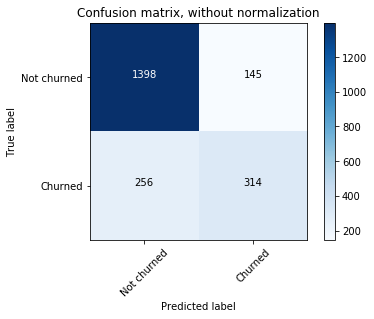

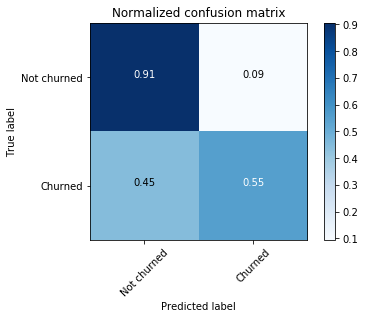

              precision    recall  f1-score   support

 Not churned       0.85      0.91      0.87      1543
     Churned       0.68      0.55      0.61       570

   micro avg       0.81      0.81      0.81      2113
   macro avg       0.76      0.73      0.74      2113
weighted avg       0.80      0.81      0.80      2113



In [17]:
from helper.helper import plot_confusion_matrix

# Compute confusion matrix
cnf_matrix = confusion_matrix(labels_test, test_y_preds)
np.set_printoptions(precision=2)

class_names = ['Not churned','Churned']

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, 
                      classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, 
                      classes=class_names, 
                      normalize=True,
                      title='Normalized confusion matrix')

plt.show()

eval_metrics = classification_report(labels_test, test_y_preds, target_names=class_names)
print(eval_metrics)

In [26]:
# delete endpoint
linear_predictor.delete_endpoint()

____

## Results
The Gradient Boosting Model performed better than the LinearLearner in both accuracy, precision and recall so we will use this tuned model to make predictions.